In [66]:
from dataclasses import dataclass
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

In [67]:
wind_data = pd.read_csv("wind_data.csv.gz")
wind_data

1/1/2002  00:00       -99999  2.0394   2.358  2.7312  2.8151  \
0          1/1/2002  00:01 -99999.00000  2.3720  2.6570  2.7907  2.8560   
1          1/1/2002  00:02 -99999.00000  2.8346  3.3486  3.5522  2.9207   
2          1/1/2002  00:03 -99999.00000  2.6098  2.9824  3.4231  2.8354   
3          1/1/2002  00:04 -99999.00000  2.9823  3.2205  3.5745  2.8801   
4          1/1/2002  00:05 -99999.00000  2.7109  3.0260  3.3804  2.8681   
...             ...    ...          ...     ...     ...     ...     ...   
10562421  1/11/2022  23:55     -1.32498  1.1410  1.1900  1.5690  1.9180   
10562422  1/11/2022  23:56     -1.35014  1.0890  1.3170  1.7190  1.6190   
10562423  1/11/2022  23:57     -1.37809  1.3320  1.3470  1.5670  1.6080   
10562424  1/11/2022  23:58     -1.30541  1.3170  1.2470  1.3380  0.8910   
10562425  1/11/2022  23:59     -1.16844  0.7130  0.7160  0.8210  0.1470   

          4.1876  4.1892   32.418  
0         4.0661  4.3228   31.619  
1         4.2418  4.1098   31.615  
2         3.5784  3.6317   32.494  
3         3.7960  3.8350   31.677  
4         3.7433  3.8940   32.482  
...          ...     ...      ...  
10562421  3.5030  4.7550  324.100  
10562422  3.0610  4.4580  340.800  
10562423  3.9280  4.0260  335.300  
10562424  3.1650  3.7430  337.200  
10562425  2.9090  3.9430  345.800  

[10562426 rows x 10 columns]

In [68]:
raw_np_data = wind_data.to_numpy()
# raw_np_data = raw_np_data[0:1000000]
raw_np_data

array([['1/1/2002', '00:01', -99999.0, ..., 4.0661, 4.3228, 31.619],
       ['1/1/2002', '00:02', -99999.0, ..., 4.2418, 4.1098, 31.615],
       ['1/1/2002', '00:03', -99999.0, ..., 3.5784, 3.6317, 32.494],
       ...,
       ['1/11/2022', '23:57', -1.37809, ..., 3.928, 4.026, 335.3],
       ['1/11/2022', '23:58', -1.30541, ..., 3.165, 3.743, 337.2],
       ['1/11/2022', '23:59', -1.16844, ..., 2.909, 3.943, 345.8]],
      dtype=object)

In [69]:
# add two columns so we can expand the date from m/d/y into m, d, y. Also, convert the time from hh:mm into h * 60 + m
adjusted_data = np.zeros([raw_np_data.shape[0], raw_np_data.shape[1] + 2])
c = 0
for r in range(raw_np_data.shape[0]):
    mdy = raw_np_data[r, 0].split("/")
    adjusted_data[r, 0:3] = mdy
    hm = raw_np_data[r, 1].split(":")
    adjusted_data[r, 3] = int(hm[0]) * 60 + int(hm[1])
    adjusted_data[r, 4:] = raw_np_data[r, 2:]

adjusted_data

array([[1.0000e+00, 1.0000e+00, 2.0020e+03, ..., 4.0661e+00, 4.3228e+00,
        3.1619e+01],
       [1.0000e+00, 1.0000e+00, 2.0020e+03, ..., 4.2418e+00, 4.1098e+00,
        3.1615e+01],
       [1.0000e+00, 1.0000e+00, 2.0020e+03, ..., 3.5784e+00, 3.6317e+00,
        3.2494e+01],
       ...,
       [1.0000e+00, 1.1000e+01, 2.0220e+03, ..., 3.9280e+00, 4.0260e+00,
        3.3530e+02],
       [1.0000e+00, 1.1000e+01, 2.0220e+03, ..., 3.1650e+00, 3.7430e+00,
        3.3720e+02],
       [1.0000e+00, 1.1000e+01, 2.0220e+03, ..., 2.9090e+00, 3.9430e+00,
        3.4580e+02]])

In [70]:
@dataclass
class PlotInfo:
    data: List[np.ndarray]
    title: str
    labels: List[str]
    yRange: List[float]
    color: str



In [85]:
def rolling_average(data: np.ndarray, window_size: int):
    smooth_data = np.zeros(data.shape)
    for i in range(data.shape[0]):
        start = max(0, i - window_size)
        end = min(data.shape[0], i + window_size)
        smooth_data[i] = np.mean(data[start: end])
    return smooth_data

In [86]:
def slice_by_minute(wind_speed_data: np.ndarray, column: int):
    sliced_data = [[] for i in range(24 * 60)]

    for r in range(wind_speed_data.shape[0]):
        minute_of_day = int(wind_speed_data[r, 3])
        wind_speed = wind_speed_data[r, column]
        if wind_speed > 0:
            sliced_data[minute_of_day].append(wind_speed)

    mean_values = np.zeros([24 * 60])
    for r in range(len(sliced_data)):
        mean_values[r] = np.mean(sliced_data[r])
    return rolling_average(mean_values, 10)



In [87]:
def make_plot_info(wind_speed_data: np.ndarray, title: str) -> PlotInfo:
    labels = ["2 meters", "5 meters", "10 meters", "20 meters", "50 meters", "80 meters", ]
    mws = [slice_by_minute(wind_speed_data, column) for column in [5, 6, 7, 8, 9, 10]]
    return PlotInfo(mws, title, labels=labels, yRange=[0, 10])


In [107]:
month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November",
          "December", ]


def filter_by_month(data: np.ndarray, month: int):
    return data[data[:, 0] == month + 1]


def filter_by_wind_direction(data: np.ndarray, start_direction: float, end_direction: float):
    wind_direction = data[:, 11]
    mm = [start_direction <= d < end_direction for d in wind_direction]
    return data[mm]

In [89]:
plot_info_by_month = []
for m in range(12):
    wsd = filter_by_month(adjusted_data, m)
    # print(f"filtered by month.shape {wsd.shape}")
    pi = make_plot_info(wsd, f"Wind Speed by Time of Day for {month_names[m]}")
    plot_info_by_month.append(pi)

In [90]:
plot_info_by_direction = []
n_directions = 8
step = 360 / n_directions
for d in range(8):
    start = d * step
    end = d * step + step
    wsd = filter_by_wind_direction(adjusted_data, start, end)
    pi = make_plot_info(wsd, f"Wind Speed by Time of Day for direction {start} to {end}")
    plot_info_by_direction.append(pi)

In [110]:
def make_line_plot(plotInfo: List[PlotInfo], title: str,
                   n_rows: int, n_cols: int,
                   xlabel: str = "Minute of Day",
                   ylabel: str = "Wind Speed"):
    import matplotlib as mpl
    mpl.rcParams['figure.dpi'] = 300
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 20))
    fig.suptitle(title, color="black", fontsize=22)
    fig.set_facecolor("white")

    for i in range(len(plotInfo)):
        row = i // n_cols
        col = i % n_cols
        if n_rows == 1 and n_cols == 1:
            a = axes
        else:
            a = axes[row][col]

        a.set_title(plotInfo[i].title, fontsize=18)
        # print(f"i {i} title {plotInfo[i].title}")
        a.set_ylabel(ylabel, fontsize = 20.0)
        a.set_xlabel(xlabel, fontsize = 20.0)
        for j in range(len(plotInfo[i].data)):
            nSamples = plotInfo[i].data[j].shape[0]
            a.plot(range(nSamples), plotInfo[i].data[j], label=plotInfo[i].labels[j])
            a.legend()

In [92]:
plot_info_by_direction[0].data[0]

array([1.74314025, 1.73973779, 1.73795716, ..., 1.73307691, 1.73583662,
       1.73641637])

In [93]:
plot_info_by_direction[1].data[0]

array([1.55634282, 1.55988901, 1.55939572, ..., 1.59661667, 1.59301666,
       1.58777062])

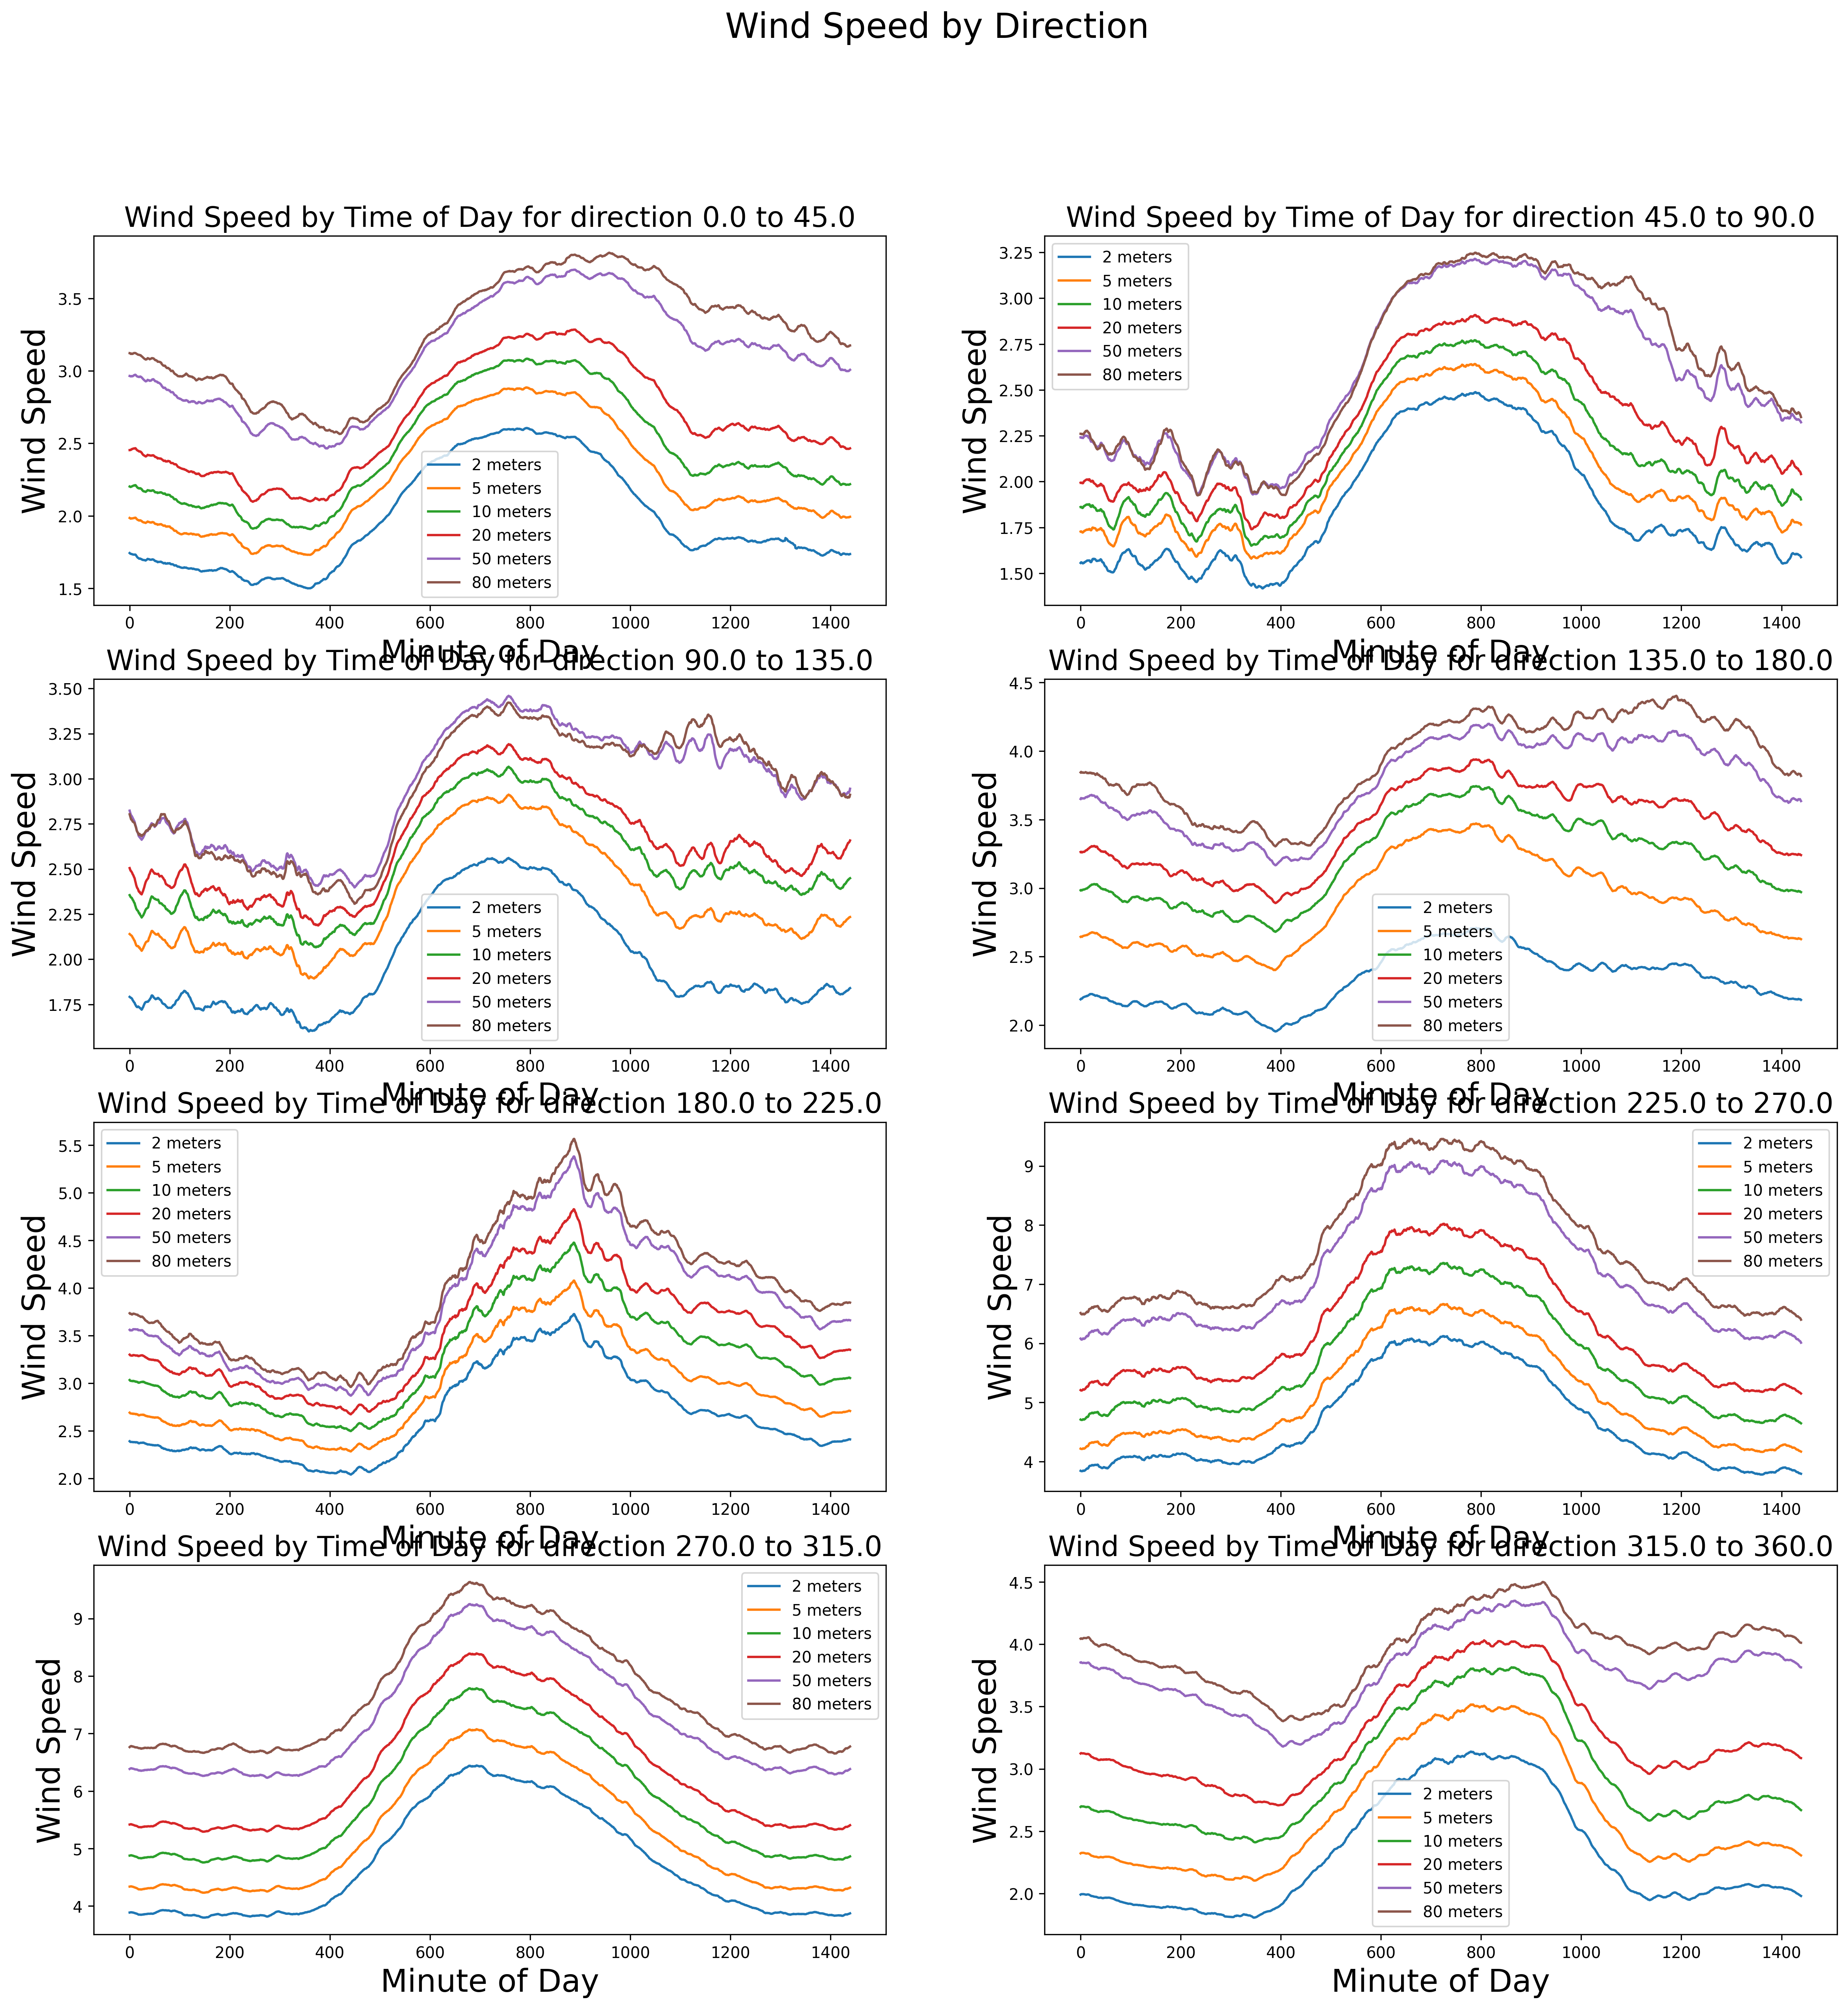

In [113]:
make_line_plot(plot_info_by_direction, "Wind Speed by Direction", 4, 2, "Minute of Day", "Wind Speed")
plt.savefig("wind_by_direction.png")

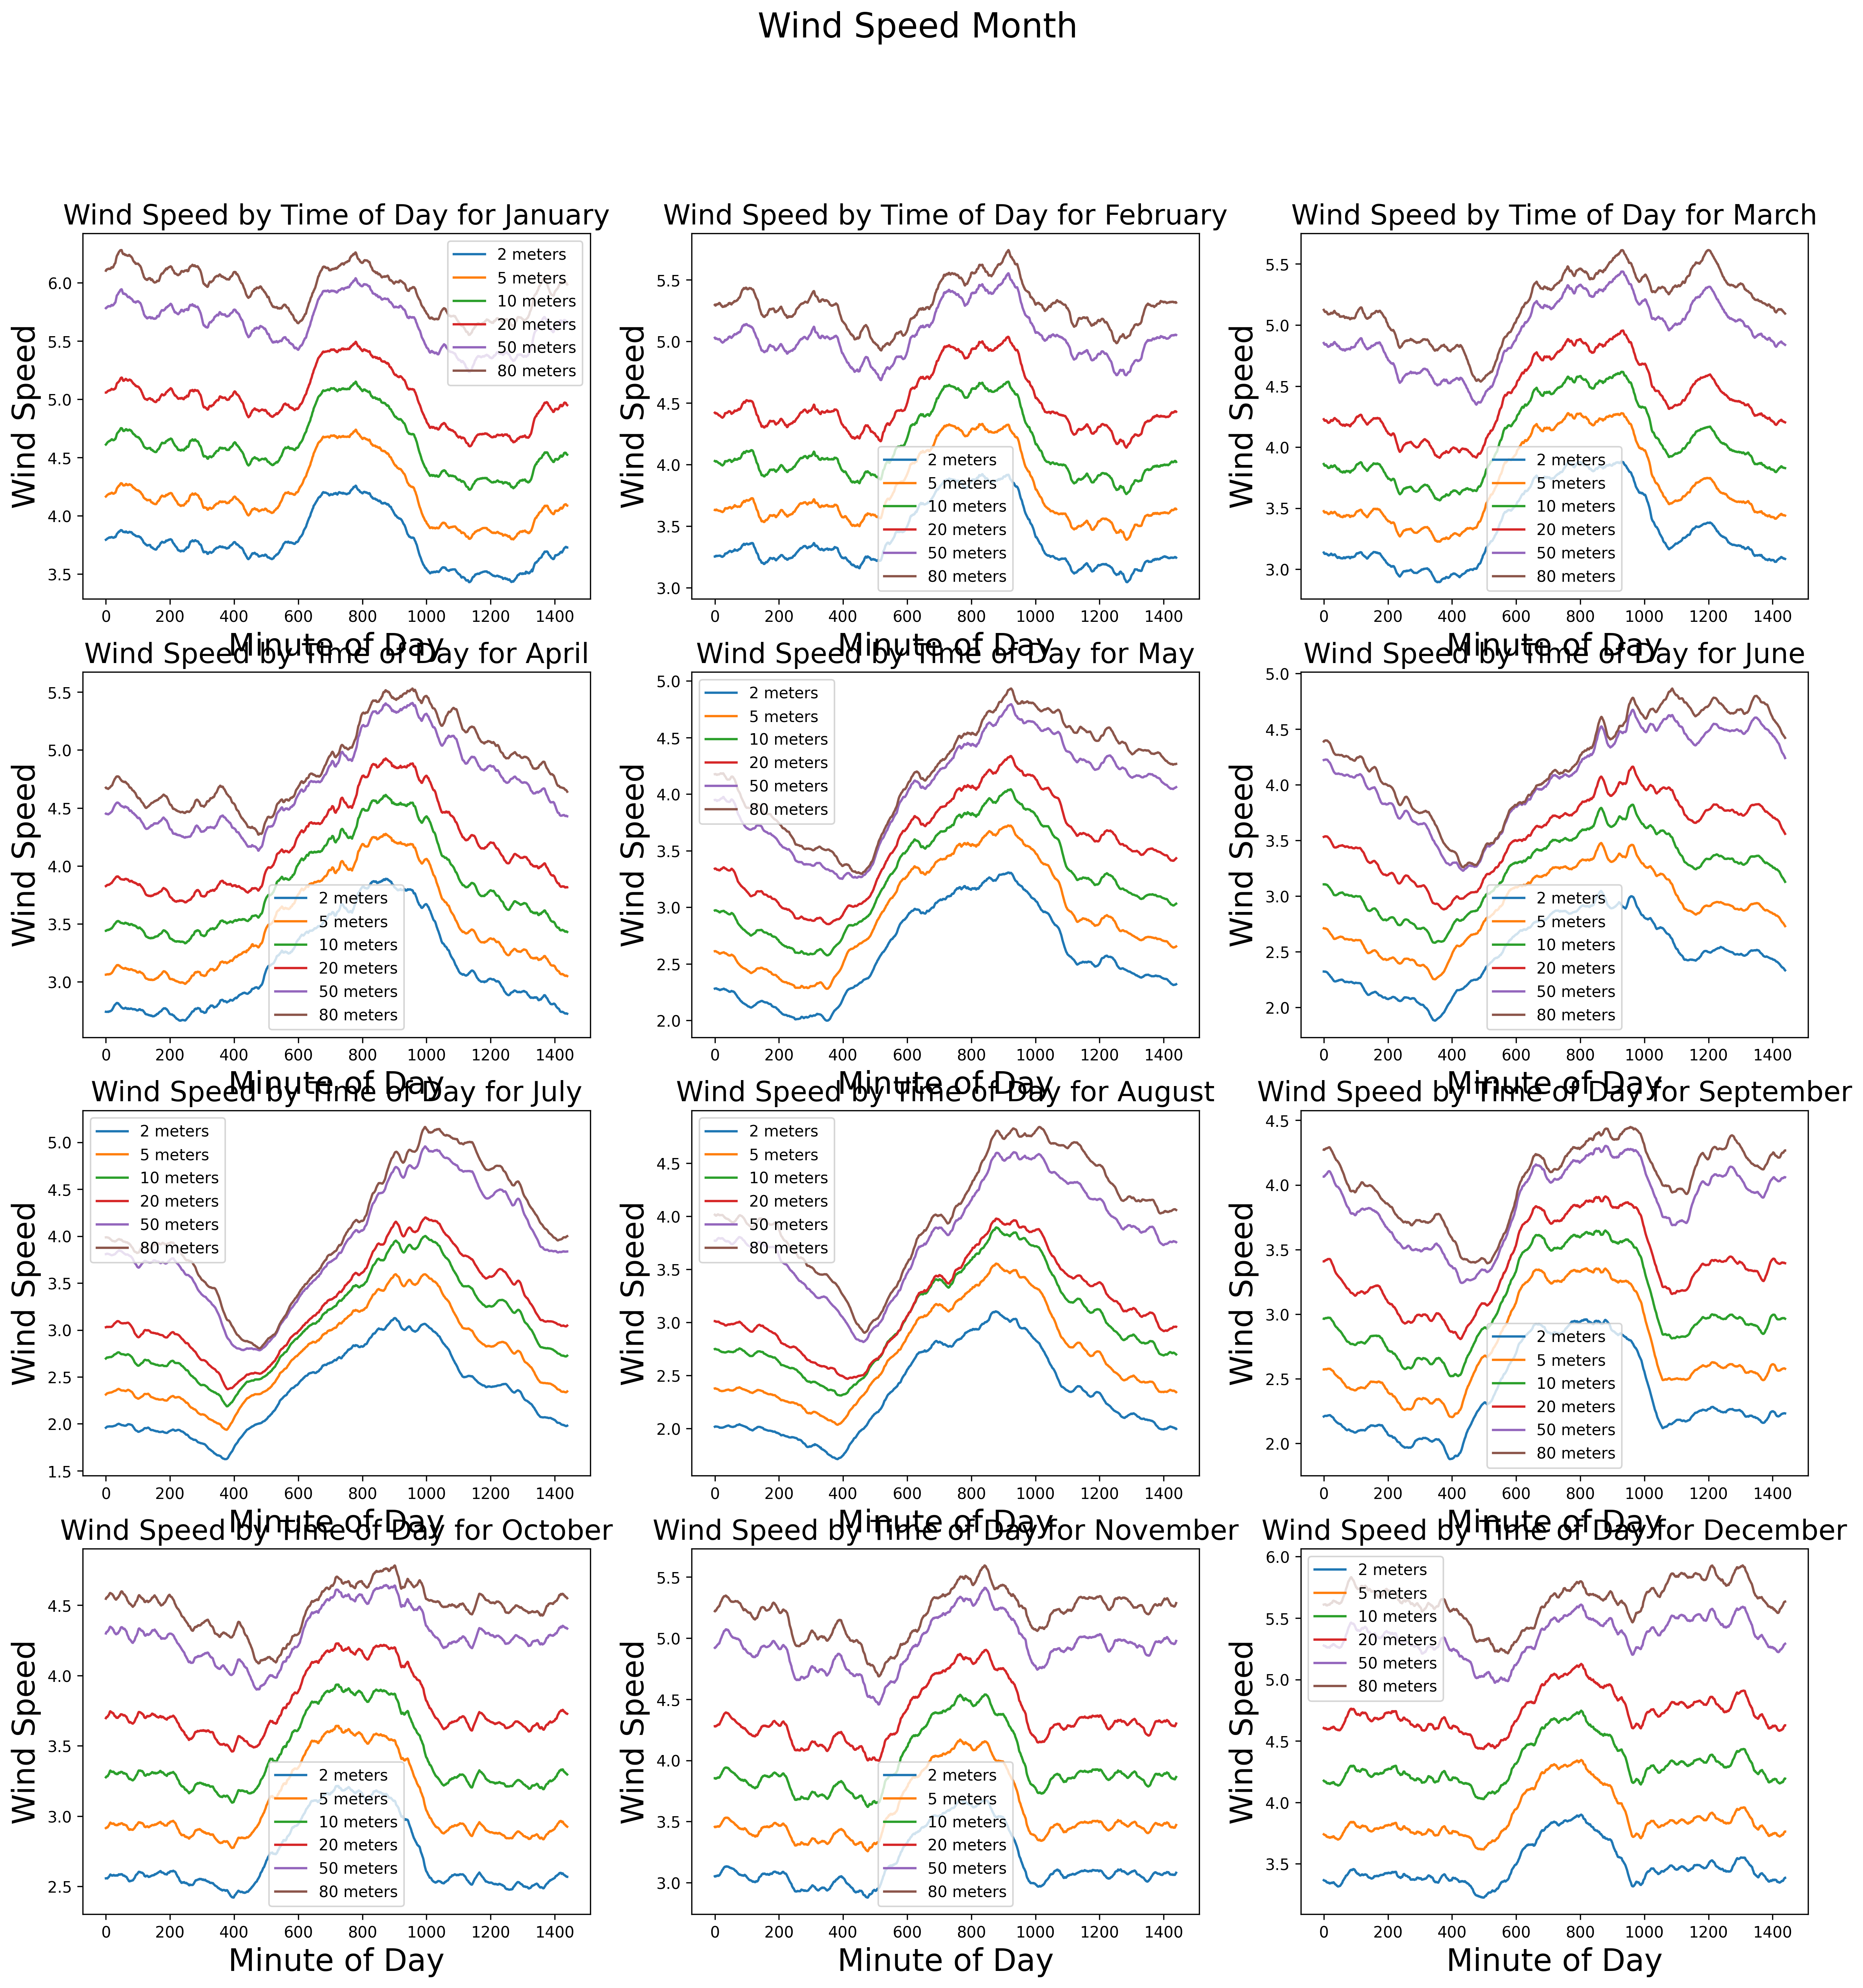

In [114]:
make_line_plot(plot_info_by_month, "Wind Speed Month", 4, 3, "Minute of Day", "Wind Speed")
plt.savefig("wind_by_month.png")

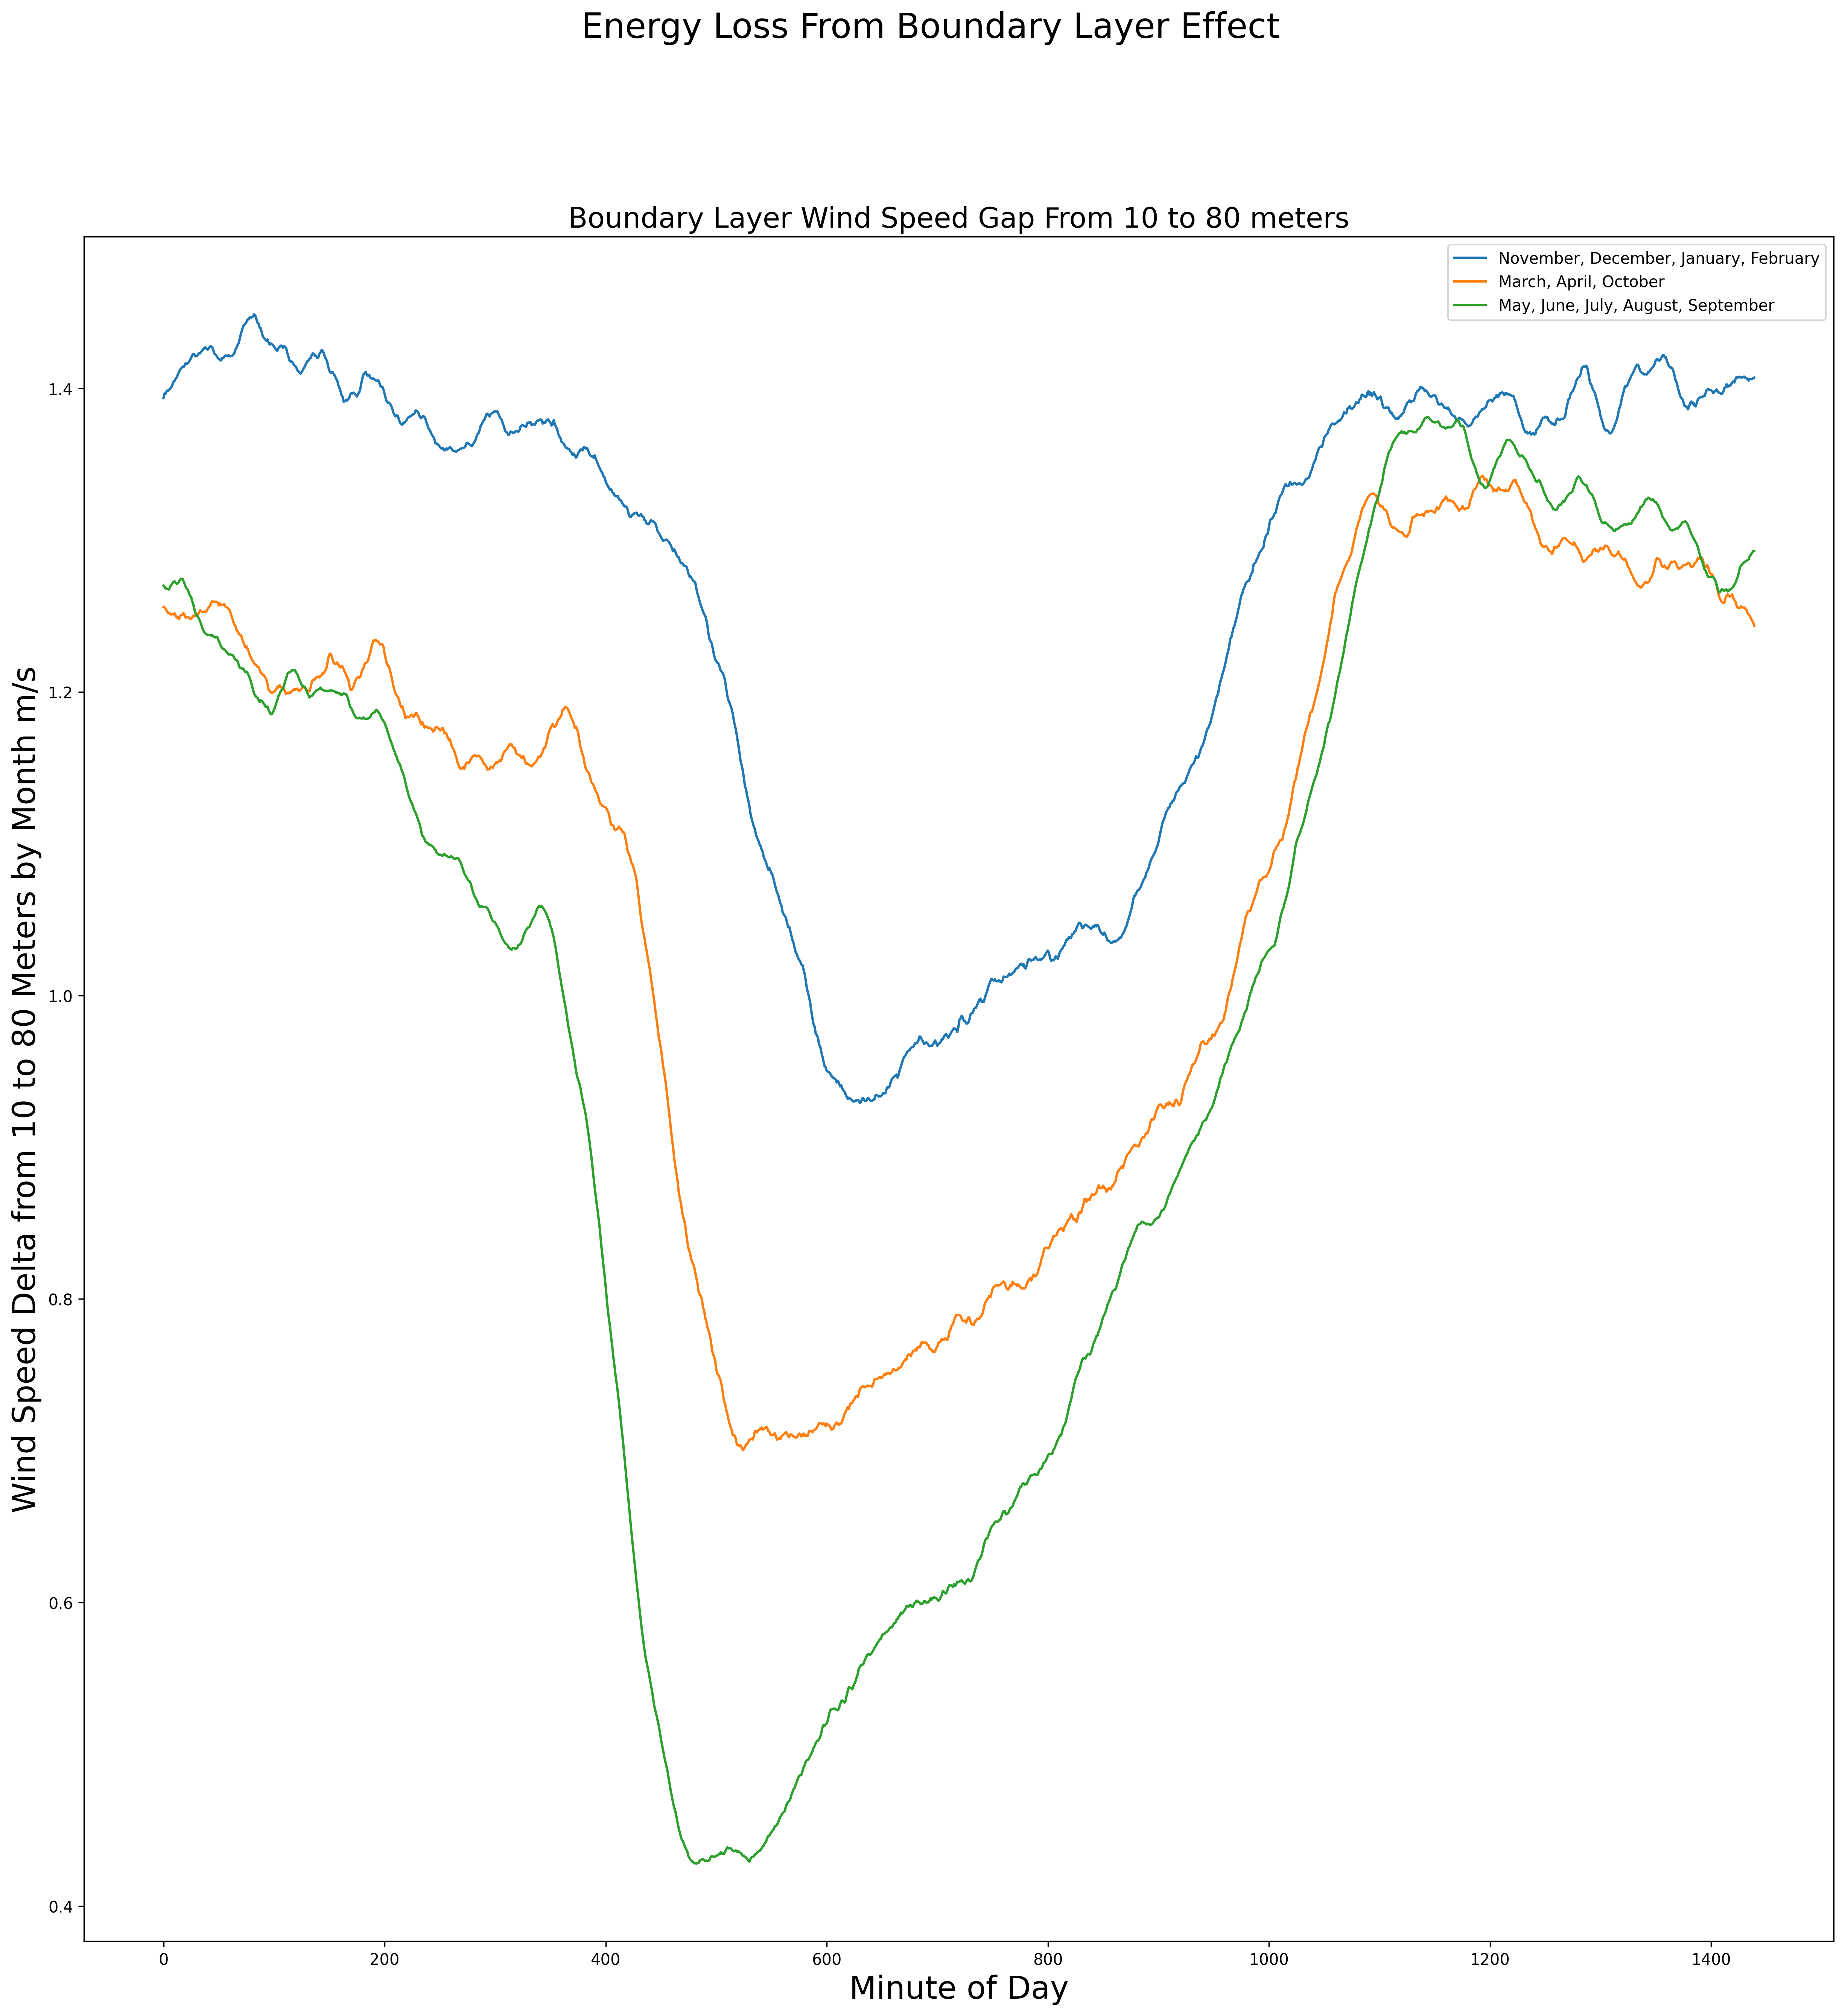

In [112]:
def get_boundary_magnitude(wind_speed_data: np.ndarray):
    speed_at_10 = slice_by_minute(wind_speed_data, 7)
    speed_at_80 = slice_by_minute(wind_speed_data, 10)
    boundary_effect = speed_at_80 - speed_at_10
    return boundary_effect

def filter_by_month_group(wind_speed_data: np.ndarray, month_group: List[int]):
    mm = [filter_by_month(wind_speed_data, m) for m in month_group]
    return np.vstack(mm)




def plot_boundary_effects_by_month(wind_speed_data: np.ndarray):

    g1 = [10, 11,0,1]
    g2 = [2,3,9]
    g3 = [4,5,6,7,8]
    month_groups = [g1, g2, g3]


    boundary_effects = []
    for month_group in month_groups:
        filtered_data = filter_by_month_group(wind_speed_data, month_group)
        boundary_effect = get_boundary_magnitude(filtered_data)
        boundary_effects.append(boundary_effect)

    group_labels = [', '.join([month_names[month] for month in group]) for group in month_groups]

    plot_info = PlotInfo(boundary_effects, "Boundary Layer Wind Speed Gap From 10 to 80 meters", group_labels, [.25, 1.75])
    make_line_plot([plot_info], "Energy Loss From Boundary Layer Effect", 1, 1,
                   "Minute of Day",
                   "Wind Speed Delta from 10 to 80 Meters by Month m/s")




plot_boundary_effects_by_month(adjusted_data)
plt.savefig("boundary_layer_effect.png")
